# FastSMC example notebook

This notebook demonstrates how to use the FastSMC python bindings.

Please make sure you have installed the python bindings by following the instructions in `../README.md` before attempting to run this notebook.

1. import the necessary modules, including from `asmc` which is installed with the Python bindings

In [1]:
import os
import numpy as np
import pandas as pd

from asmc import (
    HMM,
    DecodingQuantities,
    DecodingParams,
    Data,
    DecodingMode,
    FastSMC,
)

2. Find the example data provided with ASMC that we will use for this notebook

In [2]:
# Get the ASMC directory and check we're in the expected place
base_dir = os.path.abspath('..')
assert 'FILES' in os.listdir(base_dir)
assert 'README.md' in os.listdir(base_dir)

file_dir = os.path.join(base_dir, 'FILES', 'FASTSMC_EXAMPLE')
name_prefix = 'out.25.n300.chr2.len30.dens1.disc10-20-2000.demoCEU.mapnorm.array'
decoding_quantities_file = os.path.join(file_dir, f'{name_prefix}.decodingQuantities.gz')
assert os.path.isfile(decoding_quantities_file)

# Ouput files will be generated alongside this notebook in a directory named 'tmp_output'
output_dir = os.path.join(base_dir, 'notebooks', 'tmp_output')
os.makedirs(output_dir, exist_ok=True)
assert(os.path.isdir(output_dir))

3. Set the required parameters

In [3]:
params = DecodingParams()
params.decodingQuantFile = decoding_quantities_file
params.inFileRoot = os.path.join(file_dir, name_prefix)
params.outFileRoot = os.path.join(output_dir, 'fastsmc_output')
params.decodingModeString = 'array'
params.decodingMode = DecodingMode.arrayFolded
params.foldData = True
params.usingCSFS = True
params.batchSize = 32
params.recallThreshold = 3
params.min_m = 1.5
params.GERMLINE = False
params.FastSMC = True
params.BIN_OUT = False
params.time = 50
params.noConditionalAgeEstimates = True
params.doPerPairMAP = True
params.doPerPairPosteriorMean = True
params.jobs = 5   # for larger analysis, run with multiple jobs and jobInd = 1...N

4. Create the Python ASMC objects and run all five jobs.  This will probably take around 5-10 minutes on a laptop.

In [4]:
decoding_quantities = DecodingQuantities(params.decodingQuantFile)
sequence_length = Data.countHapLines(params.inFileRoot)

use_known_seed = False
use_batches = not params.noBatches
scaling_skip = 1

for job_ind in range(params.jobs):
    params.jobInd = 1 + job_ind   # params.jobInd is from 1...N
    data = Data(params.inFileRoot, sequence_length, decoding_quantities.CSFSSamples,
                params.foldData, params.usingCSFS, params.jobInd, params.jobs, use_known_seed)

    hmm = HMM(data, decoding_quantities, params, use_batches, 1)

    fast_smc = FastSMC()
    fast_smc.run(params, data, hmm)

5. Concatenate data

In [5]:
for job_ind in range(params.jobs):
    assert os.path.isfile(f'{params.outFileRoot}.{1 + job_ind}.{params.jobs}.FastSMC.ibd.gz')

frames = [pd.read_csv(f'{params.outFileRoot}.{x}.{params.jobs}.FastSMC.ibd.gz', sep='\t', header=None)
          for x in range(1, params.jobs + 1)]

all_data = pd.concat(frames)

col_names = ['ind1_famid', 'ind1_id', 'ind1_hap', 'ind2_famid', 'ind2_id', 'ind2_hap',
             'chromosome', 'ibd_start', 'ibd_end', 'ibd_score', 'map_est', 'post_est']

all_data.columns = col_names
all_data

,ind1_famid,ind1_id,ind1_hap,ind2_famid,ind2_id,ind2_hap,chromosome,ibd_start,ibd_end,ibd_score,map_est,post_est
0,1_1,1_1,1,1_1,1_1,2,1,10992976,11192584,0.001250,3696.742432,124.999809
1,1_1,1_1,2,1_2,1_2,1,1,8223086,8406133,0.000534,1379.476196,264.999725
2,1_1,1_1,2,1_2,1_2,1,1,29720657,29999458,0.000691,2259.799072,224.999741
3,1_1,1_1,1,1_2,1_2,2,1,6897571,7116793,0.001590,3372.529785,144.999802
4,1_1,1_1,1,1_2,1_2,2,1,20701135,20828119,0.000549,2909.363770,214.999756
...,...,...,...,...,...,...,...,...,...,...,...,...
12024,1_148,1_148,1,1_150,1_150,2,1,8740,288623,0.000506,1774.285034,354.999634
12025,1_149,1_149,1,1_150,1_150,1,1,16153232,16278498,0.000847,2394.331055,194.999771
12026,1_149,1_149,2,1_150,1_150,1,1,2994701,3159682,0.000640,3101.042969,164.999786
12027,1_149,1_149,1,1_150,1_150,2,1,16797953,16978455,0.000476,2209.393311,244.999741


6. Visualise data: here we simply bin the posterior age estimates of the IBD segments

<AxesSubplot:>

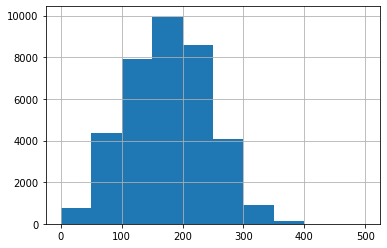

In [6]:
all_data['post_est'].hist(range=[0, 500])